# Set Up Environment

## Dependencies

In [1]:
import importlib
import numpy as np
import pandas as pd
import os
import IPython
import netCDF4 as nc
import  xarray as xr
from datetime import datetime, timedelta

In [2]:
# Recognize the current operating system
if os.name == "nt":  # Windows
    delimiter = "\\"
else:  # Unix or Linux
    delimiter = "/"

In [3]:
# return to the parent directory to import relative functions
os.chdir("..")
from src.data.process import create_dataframe_from_nc, iterate_months
from src.model.predict import *
from src.model.features import *
os.getcwd()

'c:\\Users\\liang.yang\\Desktop\\esmeraldas'

In [5]:
features = get_ccs_features("data/basins/esmeraldas.gpkg", 'https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/3hrly/rgccs3h2405512.bin.gz')

File downloaded successfully: c:\Users\liang.yang\Desktop\esmeraldas\rgccs3h2405512.bin.gz
None


In [5]:
stat_ana_features(features)

Count (non-NaN): 1098
Sum (non-NaN): 699.0
Mean (non-NaN): 0.6366119980812073
Median (non-NaN): 0.0
Standard Deviation (non-NaN): 3.07936429977417
Minimum (non-NaN): 0.0
Maximum (non-NaN): 46.31999969482422
Quartiles (non-NaN and non-0): [0.38499999 1.47000003 5.27499986]


# Baseline

In [14]:
base_file = create_dataframe_from_nc(3, 'data/raw/clipping_test/CCS_esmJSON_2024-06-04091904am.nc')
base_timestamp = base_file.index[2]
print(f'the timesamp is {base_timestamp}')
from datetime import datetime
date = base_timestamp.date()
print(f'which is the {date.timetuple().tm_yday}th day of the year')
base = np.array(base_file.iloc[2])
base = base.reshape(53,52)

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/clipping_test/CCS_esmJSON_2024-06-04091904am.nc'

# Alternatives

In [60]:
import geopandas as gpd
# get the shape file of the Esmeraldas basin
esm_shape_file=gpd.read_file("data/basins/esmeraldas.gpkg")

### Localized algo

In [63]:
# original localized algo by Carlos
from src.model.predict import *
local_algo_full = read_persiann_ccs('data/raw/clipping_test/rgccs3h2405106.bin.gz')
tif_path = convert_to_geotiff(local_algo_full)
chrs_clipped_path = clip_raster_with_gpkg(tif_path,esm_shape_file)
with rasterio.open(chrs_clipped_path) as src:
    clipped_raster_array = src.read(1)
os.remove(chrs_clipped_path)
os.remove(tif_path)
local_algo_clipped = clipped_raster_array
print(f'the local algo clipped shape is {local_algo_clipped.shape}')

the local algo clipped shape is (52, 51)


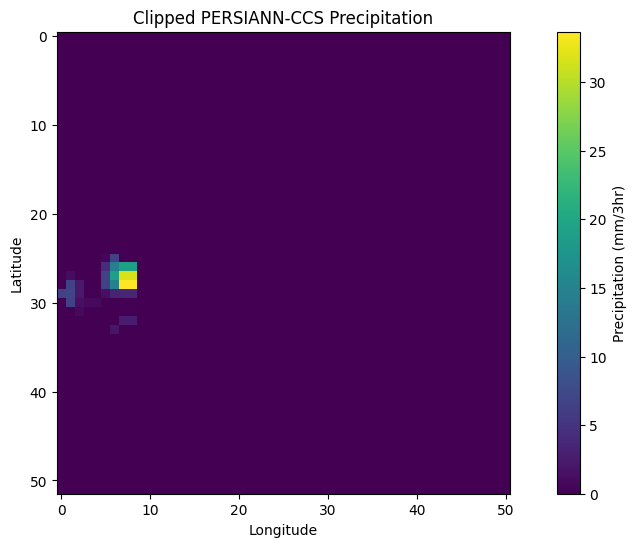

In [70]:
# Paths
file_path = 'data/raw/clipping_test/rgccs3h2405106.bin.gz'
geotiff_path = 'data/raw/clipping_test/rgccs3h3h2405106.tif'
gpkg_path = 'data/basins/esmeraldas.gpkg'
clipped_raster_path = 'data/raw/clipping_test/clipped_rgccs3h0300100.tif'

# Read and convert the data to GeoTIFF
data = read_persiann_ccs(file_path)
convert_to_geotiff(data, geotiff_path)

# Clip the GeoTIFF with the geopackage shapefile
clip_raster_with_gpkg(geotiff_path, gpkg_path, clipped_raster_path)

# Plot the clipped data
plot_clipped_data(clipped_raster_path)

In [75]:
import tifffile

# Replace 'your_image.tif' with the path to your file
image_array = tifffile.imread('data/raw/clipping_test/clipped_rgccs3h0300100.tif')
print(f'the shape of the clipped raster is {image_array.shape}')

the shape of the clipped raster is (52, 51)


# Baseline of .tif

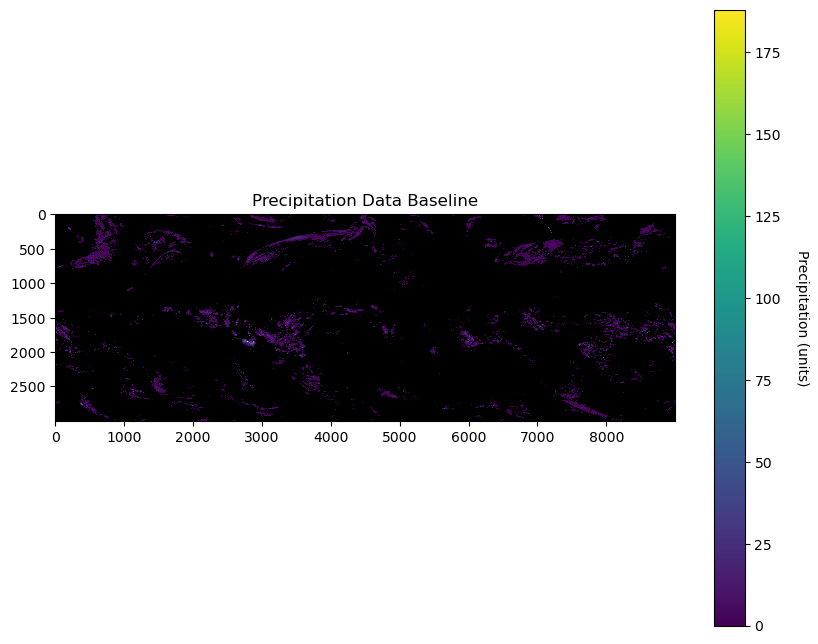

Shape of the data: (3000, 9000)


In [9]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def visualize_precipitation_data(tiff_file_path):
    # Read the TIFF file
    tif_file = tifffile.imread(tiff_file_path)

    # If the file contains multiple pages (3D dataset), you can access individual pages like this:
    # tif_file = tif_file[0]  # Access the first page

    # Convert the TIFF data to a NumPy array
    precipitation_data_base = np.array(tif_file, dtype=np.float32)  # Ensure the data type is float

    # Create a custom colormap
    cmap = plt.get_cmap('viridis', 256)  # Higher resolution colormap
    cmap.set_under('k', alpha=1)  # Set color for values <= -99 to black

    # Replace pixels with value -99 with a very low value (-1000)
    precipitation_data_base[precipitation_data_base == 0] = -1000

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the precipitation data as an image
    im = ax.imshow(precipitation_data_base, cmap=cmap, interpolation='nearest', vmin=0)

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Precipitation (units)', rotation=270, labelpad=20)

    # Add a title
    ax.set_title('Precipitation Data Baseline')

    # Show the plot
    plt.show()

    # Print the shape of the data
    print(f'Shape of the data: {precipitation_data_base.shape}')

# Usage example
visualize_precipitation_data('data/raw/clipping_test/CCS_3h2024022006.tif')

# Test

In [4]:
import gzip
import rasterio
from rasterio.transform import from_origin
import numpy as np

import gzip
import rasterio
from rasterio.transform import from_origin
import numpy as np
from affine import Affine

def convert_bin_gz_to_tif(input_filepath, output_filepath, ncol, nrow, upper_left_x, upper_left_y, pixel_width, pixel_height, nodata_value, crs):
    """
    Converts a compressed binary file (.bin.gz) to a GeoTIFF file (.tif).

    Args:
        input_filepath (str): Path to the input compressed binary file (.bin.gz).
        output_filepath (str): Path to the output GeoTIFF file (.tif).
        ncol (int): Number of columns in the raster.
        nrow (int): Number of rows in the raster.
        upper_left_x (float): X coordinate of the upper-left corner of the raster.
        upper_left_y (float): Y coordinate of the upper-left corner of the raster.
        pixel_width (float): Width of each pixel.
        pixel_height (float): Height of each pixel.
        nodata_value (float or int): Value representing no data.
        crs (str or rasterio.crs.CRS): Coordinate reference system of the raster.

    Returns:
        None
    """
    # Decompress the binary data
    with gzip.open(input_filepath, 'rb') as f_in:
        decompressed_data = f_in.read()

    # Determine the data type of the binary data
    data_type = np.dtype('>i2')

    # Create a NumPy array from the decompressed data
    binary_array = np.frombuffer(decompressed_data, data_type)
    binary_array = binary_array.reshape(nrow, ncol)

    # Convert the data type to float32 and replace nodata values with np.nan
    binary_array = binary_array.astype(np.float32)
    binary_array[binary_array == nodata_value] = np.nan

    # Apply unit conversion (mm/3hr * 100)
    binary_array *= 0.01  # Convert from (mm/3hr * 100) to mm/3hr
    binary_array = np.around(binary_array, decimals=2)

    transform = Affine.from_gdal(upper_left_x, pixel_width, 0, upper_left_y, 0, pixel_height)

    # Create the GeoTIFF file
    with rasterio.open(output_filepath, 'w', driver='GTiff', height=nrow, width=ncol, count=1, dtype=binary_array.dtype, nodata=np.nan, crs=crs, transform=transform) as dst:
        dst.write(binary_array, 1)
    return binary_array # Optional, just for debugging

# Example usage
input_filepath = 'data/raw/clipping_test/rgccs3h2405106.bin.gz'
output_filepath = 'output.tif'
ncol = 9000
nrow = 3000
upper_left_x = 0.0
upper_left_y = 60.0
pixel_width = 0.04
pixel_height = -0.04
nodata_value = -9999
crs = 'EPSG:4326'

raster_array = convert_bin_gz_to_tif(input_filepath, output_filepath, ncol, nrow, upper_left_x, upper_left_y, pixel_width, pixel_height, nodata_value, crs)


Min lonitude: -179.98
Max lonitude: 179.98
None


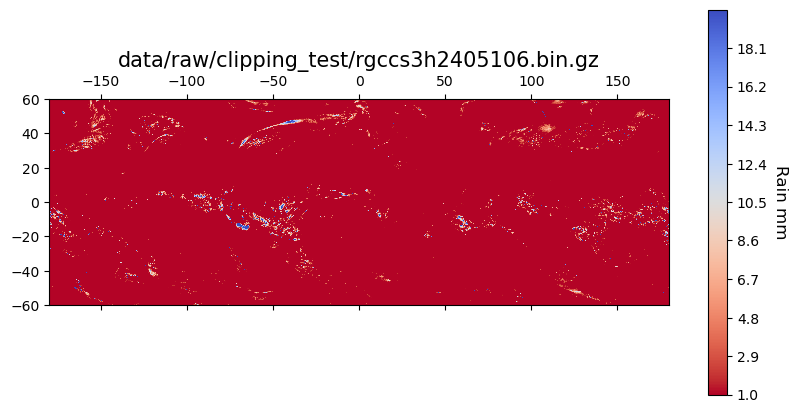

In [5]:
from pyramids.dataset import Dataset
# read the raster file
tif = Dataset.read_file(output_filepath)
new_tif = tif.convert_longitude()
print(f"Min lonitude: {min(new_tif.lon)}")
print(f"Max lonitude: {max(new_tif.lon)}")
new_tif.plot(
    band=0, figsize=(10, 5), title=input_filepath, cbar_label="Rain mm", vmax=20, vmin=1,
    cbar_length=1
)
new_tif.to_file("output_adjusted.tif")

In [5]:
gpkg_path = 'data/basins/esmeraldas.gpkg'
ccs_features = get_ccs_features(gpkg_path)

The local base time is 2024-06-17 13:00:00
 The local hour to predict is 16
The ccs file used for prediction is from https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/3hrly/rgccs3h2416915.bin.gz
File downloaded successfully: c:\Users\liang.yang\Desktop\esmeraldas\rgccs3h2416915.bin.gz
None


In [ ]:
ccs_features
# The ccs file used for prediction is from https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/3hrly/rgccs3h2416915.bin.gz

In [8]:
tif = Dataset.read_file(original_tif_filepath)
# how to release the usage of the tif object?
# so that it could be deleted from the disk cache later
new_tif = tif.convert_longitude()
adjusted_full_raster_path = 'output_adjusted.tif'
new_tif.to_file(adjusted_full_raster_path)

None


In [8]:
# get the result of the clipped array using self-defined algo
url = 'https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/3hrly/rgccs3h2405106.bin.gz'
# baseline datetime is 
downloaded_ccs_file_path = download_ccs_file(url)
shape_file_path = 'data/basins/esmeraldas.gpkg'
ccs_features_diy = make_ccs_feature_array(shape_file_path, downloaded_ccs_file_path)

File downloaded successfully: c:\Users\liang.yang\Desktop\esmeraldas\rgccs3h2405106.bin.gz
None


In [23]:
stat_ana_features(ccs_features_diy)

Count (non-NaN): 1098
Sum (non-NaN): 699.0
Mean (non-NaN): 0.6366119980812073
Median (non-NaN): 0.0
Standard Deviation (non-NaN): 3.07936429977417
Minimum (non-NaN): 0.0
Maximum (non-NaN): 46.31999969482422
Quartiles (non-NaN): [0.38499999 1.47000003 5.27499986]


In [20]:
# read the clipped raster into a numpy array of features
chrs_clipped_path = 'data/raw/clipping_test/CCS_3h2024022006.tif'
with rasterio.open(chrs_clipped_path) as src:
    clipped_raster_array = src.read(1)

# flatten and filter the 2d numpy array into a 1d array
clipped_1d = clipped_raster_array.ravel()
clipped_1d = clipped_1d.astype(float)
clipped_1d[clipped_1d == -99] = np.nan
clipped_features_chrs = clipped_1d[~np.isnan(clipped_1d)]
# eliminate the nan values in the clipped array from the chrs

In [24]:
stat_ana_features(clipped_features_chrs)

Count (non-NaN): 1098
Sum (non-NaN): 738.0
Mean (non-NaN): 0.6721311475409836
Median (non-NaN): 0.0
Standard Deviation (non-NaN): 3.0785063698389714
Minimum (non-NaN): 0.0
Maximum (non-NaN): 46.0
Quartiles (non-NaN): [1. 1. 5.]


In [4]:
get_ccs_features("data/basins/esmeraldas.gpkg")

NameError: name 'get_adjacent_multiple_of_three_plus_one' is not defined